This code is for plotting using the full model domain rather than slong specific inline or crossline sections. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 
import warnings
import scipy.integrate as integrate
import PIL
from xml.dom import minidom
# from shapely.geometry import Polygon, MultiPolygon
#from descartes import PolygonPatch
#from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

%matplotlib inline
#%matplotlib qt
#%matplotlib notebookv
#from google.colab import drive
#drive.mount("/content/gdrive")

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

Make new cmap from StratBuilder Code

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

pres_cols = ['#e08266', '#feb9a8', '#8da0ae']##for SANCAS and AGU
pres_palette = sns.color_palette(pres_cols)

In [3]:
##### Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 802800 #
#time from which we restarted the runs to add a flood
fldstart_s = 0 ##start time of flood in seconds
variabd = int(input('Enter DV flag')) #flag for if in variable discharge regime
adjustment_time = 65
fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-flux.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)



Enter DV flag 0


/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-flux.npy


In [4]:
iloc = 800#location of the section along i axis
jloc = 14#location of the secion along j axis


cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-hr-{idf}-{iloc}'

In [5]:
##define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 12, 382)


In [52]:
print(savefilesto)

/Volumes/SAF_Data/NAYS2DH_files/Plots/


In [7]:
num_timesteps = datamaster.shape[2] ## or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ##when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ##flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 12, 382)


___
# Do Facies Things
Extract an array with depth and velocity data from all timesteps, at all points. Calculate the facies on the bed. 

In [8]:

trueflow = np.reshape(datamaster[:, 4, :], (gridy, gridx, end_t))
flowvel = np.reshape(datamaster[:, 10, :], (gridy, gridx, end_t))

In [9]:
temp = 20.0 #temperature in degrees celcius
kv = (1.14-0.031*(temp-15)+0.00068*((temp-15)**2))*10**-6
print(kv)
D_star = np.power((1.65*9.81)/(1e3*(kv**2)), 0.333)*3.1e-4
print(D_star)
d50um = 310
chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?
mmprange = [0, 0.01, 0.025, 0.17, 0.35, 1.5, 10] ## LP, R, D, D-UP, UP #you have to use the zero at the beginning to account for the sub LSPB stuff
mmp_full =(p*(flowvel**2))/(1650*(chezy_rough**2)*d50)## modified mobility parameter

1.0019999999999997e-06
0.7770191533135022


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [10]:
###### levels = MaxNLocator(nbins = 5).tick_values(0.01, 10)

clist = ['#261707', 'xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone']
cmap_vvfac = ListedColormap(['#261707', 'xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone'])
# norm_vvfac = BoundaryNorm(levels, ncolors = cmap_vvfac.N, clip = True)
mmprange = [0, 0.01, 0.025, 0.17, 0.35, 1.5, 10] ## LP, R, D, D-UP, UP
norm_vvfac = BoundaryNorm(mmprange, cmap_vvfac.N)

Aug 31 2023--making a modification to this code where if dz <= 0 it is not counted in any of the frequency analyses, because if there is erosion no bforms form. 

In [11]:
## calculate true cell dimensions for each timestep

x_allt = np.reshape(datamaster[:, 2, :], (gridy, gridx, end_t))
y_allt = np.reshape(datamaster[:, 3, :], (gridy, gridx, end_t))
z_allt = np.reshape(datamaster[:, 7, :], (gridy, gridx, end_t))

print(x_allt.shape, y_allt.shape, z_allt.shape)

dz_bed = z_allt[:, :, 1:]-z_allt[:, :, :-1] ## find dz
dz_bed = dz_bed[:-1, :-1, :]

cell_lengths = x_allt[:, 1:, :]-x_allt[:, :-1, :]
cell_lengths = cell_lengths[:-1, :, :-1] ## reduce them to the same dimension by excluding data on the boundaries (transform data to grid face using lower left value as face value)
cell_widths = y_allt[1:, :, :]-y_allt[:-1, :, :]
cell_widths = cell_widths[:, :-1, :-1]

print(cell_lengths.shape, cell_widths.shape, dz_bed.shape)

## replace dz_bed <o with nans for calculating facies

dz_bed_facies = copy.deepcopy(dz_bed) ##where dz_bed is negative there will be no facies deposited so shouldnt be counted in the facies statistics
dz_bed_facies[np.isnan(dz_bed_facies)] = np.nan

dz_bed_facies = copy.deepcopy(dz_bed) 
dz_bed_facies[np.where(dz_bed_facies <= 0)] = np.nan ##replace negative or 0 values with nan values

cell_area = cell_lengths*cell_widths ##not including nan
cell_volume = cell_area*dz_bed_facies ##not includng nan
delta_area = cell_area[:, 1:, :]-cell_area[:, :-1, :] ## in cross stream direcction all cells have th same area direction

mmp_to_faces = mmp_full[:-1, :-1, :-1]
print(mmp_to_faces.shape)

(26, 1001, 382) (26, 1001, 382) (26, 1001, 382)
(25, 1000, 381) (25, 1000, 381) (25, 1000, 381)
(25, 1000, 381)


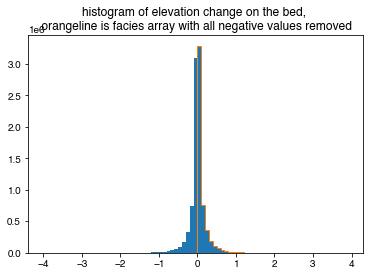

In [12]:
## see bed elevation change on the bed, compare to facies dz array made to exclude nans
plt.hist(dz_bed.ravel(), bins = np.arange(-4, 4, step = 0.1));
plt.hist(dz_bed_facies.ravel(), bins = np.arange(-4, 4, step = 0.1), histtype = 'step');
plt.title('histogram of elevation change on the bed, \n orangeline is facies array with all negative values removed');

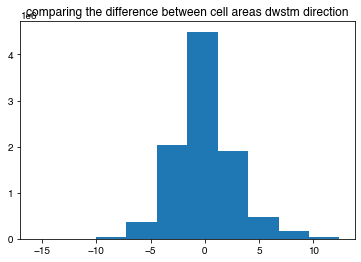

In [13]:
# plt.hist(delta_areax.ravel())
plt.hist(delta_area.ravel())
plt.title('comparing the difference between cell areas dwstm direction');

In [14]:
### import facies and frind frequencies in the stratgiraphy
## idx--0 has nothing, 1--xy_topo
arrdir = ('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/streamwise-masters/agubh2-10km-xs-250m/')
arrlist = os.listdir(arrdir)

sec_mmpdz = pd.DataFrame() ##holds facies scaled to thickness change between two timestps (calculates the facies area per cell)

secstart = 100
secstop = 901
secspace = 25
sections = np.arange(secstart, secstop, secspace)


## average values for shear stress, depth, velocity and sediment flux at each cross-section location (the 250m spaced ones). 
shearavg = np.empty([1, len(sections)])
depthavg = np.empty([1, len(sections)])
velavg = np.empty([1, len(sections)])
fluxavg = np.empty([1, len(sections)])

strat_freq = np.empty([len(mmprange)-1, len(sections)]) 
strat_freq_edges = np.empty([len(mmprange), len(sections)])
strat_percents = np.empty([len(mmprange)-1, len(sections)])
# print(strat_freq.shape)
for x, file in enumerate(arrlist):
    ##### ((xy_strat, xy_topo, shear, trueflow, flowvel, bedflux, mmp))
    
    array = np.load(arrdir+file, allow_pickle = True)
    # facarray = array[:, :, -1]
    # strat_freq[:, x], strat_freq_edges[:, x] = np.histogram(facarray[~np.isnan(facarray)].ravel(), bins = [0, 0.01, 0.025, 0.17, 0.35, 1.5, 10])
    # strat_percents[:, x] = strat_freq[:, x]/len(facarray[~np.isnan(facarray)].ravel())

    shearavg[:, x] = np.nanmean(array[:, :, 2])
    depthavg[:, x] = np.nanmean(array[:, :, 3])
    velavg[:, x] = np.nanmean(array[:, :, 4])
    fluxavg[:, x] = np.nanmean(array[:, :, 5])
    
    array[:, :, 1][np.isnan(array[:, :, -1])] = np.nan  ## where facies = nan previously ascribed in processing script. 
    dz = array[1:, :, 1]-array[:-1, :, 1] ##find the dz between two timesteps, this is stratigraphym not topography so there should be no negative numbs

    df = pd.DataFrame(zip(array[1:, :, -1].ravel(), dz.ravel()), columns = [f'{file}-mmp', f'{file}-dz'])  ## zip together the facies and the thickness change per cell to calculate area. 
    # sec_mmpdz[f'{file}-mmp'] = array[1:, :, -1].ravel()
    # sec_mmpdz[f'{file}-dz'] = dz.ravel()
    
    sec_mmpdz = pd.concat((sec_mmpdz, df), axis = 1)
    
    ## sum all locations where facies exists (since dx = 1, area of the facies is just the sum of the dz (length of the rectangle in the xs grid space))
    nomve = np.nansum(dz[np.where(array[1:, :, -1]<0.01)])

    lspb = np.nansum(dz[np.where(np.logical_and(array[1:, :, -1]>=0.01, array[1:, :, -1]<0.025))])

    rip = np.nansum(dz[np.where(np.logical_and(array[1:, :, -1]>=0.025, array[1:, :, -1]<0.17))])

    dun = np.nansum(dz[np.where(np.logical_and(array[1:, :, -1]>=0.17, array[1:, :, -1]<0.35))])

    dunuspb = np.nansum(dz[np.where(np.logical_and(array[1:, :, -1]>=0.35, array[1:, :, -1]<1.5))])

    uspb = np.nansum(dz[np.where(array[1:, :, -1]>=1.5)])

    props = [nomve, lspb, rip, dun, dunuspb, uspb]/(np.nansum(dz))
    strat_percents[:, x] = np.array([props])

In [15]:
bed_w_time = np.empty([len(mmprange)-1, 2, len(np.arange(adjustment_time, end_t-1))]) ## area and vol facies percents on bed at time (global bed area/volume)

for idx, t in enumerate(np.arange(adjustment_time, end_t-1)): 
    
    ## calculate area and volume proportions
    nomve_a = np.nansum(cell_area[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0, mmp_to_faces[:, :, t]<0.01))])
    lspb_a = np.nansum(cell_area[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.01, mmp_to_faces[:, :, t]<0.025))])
    rip_a = np.nansum(cell_area[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.025, mmp_to_faces[:, :, t]<0.17))])
    dun_a = np.nansum(cell_area[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.17, mmp_to_faces[:, :, t]<0.35))])
    dunuspb_a = np.nansum(cell_area[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.35, mmp_to_faces[:, :, t]<1.5))])
    uspb_a = np.nansum(cell_area[:, :, t][np.where(mmp_to_faces[:, :, t]>=1.5)])
    
    nomve_v = np.nansum(cell_volume[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0, mmp_to_faces[:, :, t]<0.01))])
    lspb_v = np.nansum(cell_volume[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.01, mmp_to_faces[:, :, t]<0.025))])
    rip_v = np.nansum(cell_volume[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.025, mmp_to_faces[:, :, t]<0.17))])
    dun_v = np.nansum(cell_volume[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.17, mmp_to_faces[:, :, t]<0.35))])
    dunuspb_v = np.nansum(cell_volume[:, :, t][np.where(np.logical_and(mmp_to_faces[:, :, t]>=0.35, mmp_to_faces[:, :, t]<1.5))])
    uspb_v = np.nansum(cell_volume[:, :, t][np.where(mmp_to_faces[:, :, t]>=1.5)])
        
    
    props_a = [nomve_a, lspb_a, rip_a, dun_a, dunuspb_a, uspb_a]/(np.nansum(cell_area[:, :, t]))
    bed_w_time[:, 0, idx] = np.array([props_a])
    
    props_v = [nomve_v, lspb_v, rip_v, dun_v, dunuspb_v, uspb_v]/(np.nansum(cell_volume[:, :, t]))
    bed_w_time[:, 1, idx] = np.array([props_v])


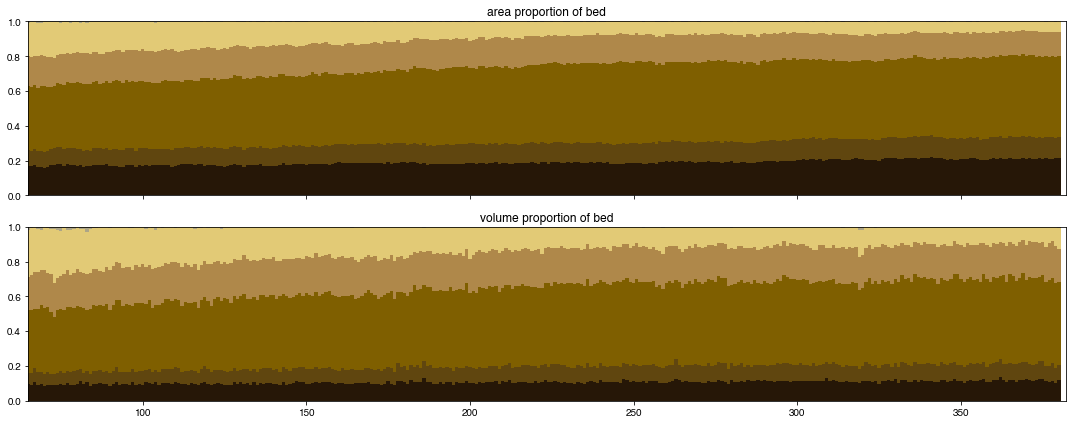

In [16]:
fig, ax = plt.subplots(2, figsize = (15, 6), tight_layout = True, sharex = True, sharey = True)
w = 1
timesteps = np.arange(adjustment_time, end_t-1)
area_bottoms = np.cumsum(bed_w_time[:, 0, :], axis = 0) # find the base of each of the bars for the bar chart
vol_bottoms = np.cumsum(bed_w_time[:, 1, :], axis = 0)
# ax[0].set_xlim(sections.min(), sections.max())
ax[0].set_xlim(adjustment_time, end_t)
ax[0].set_ylim(0, 1)
# for i in range (0, gridx, 10):
# for i in range(len(sections)):
ax[0].set_title('area proportion of bed')
ax[1].set_title('volume proportion of bed')
ax[0].bar(timesteps, bed_w_time[0, 0, :], w, color=clist[0])
ax[1].bar(timesteps, bed_w_time[0, 1, :], w, color=clist[0])

for i in range(1, len(mmprange)-1):
    ax[0].bar(timesteps, bed_w_time[i, 0, :], w, bottom = area_bottoms[i-1, :], color = clist[i])
    ax[1].bar(timesteps, bed_w_time[i, 1, :], w, bottom = vol_bottoms[i-1, :], color = clist[i])        

In [17]:
## calculate area of the bed covered by specific caies at each section at each timestep 
# (this is normalised to each timestep so you could do this if you wanted to plot a couple timesteps)
bed_percents = np.empty([len(mmprange)-1, len(sections), len(np.arange(adjustment_time, end_t-1))])

for t in range(adjustment_time, end_t-1): 
    for idx, x in enumerate(sections):

        nomve = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0, mmp_to_faces[:, x, t]<0.01))])

        lspb = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.01, mmp_to_faces[:, x, t]<0.025))])

        rip = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.025, mmp_to_faces[:, x, t]<0.17))])

        dun = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.17, mmp_to_faces[:, x, t]<0.35))])

        dunuspb = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.35, mmp_to_faces[:, x, t]<1.5))])

        uspb = np.nansum(cell_area[:, x, t][np.where(mmp_to_faces[:, x, t]>=1.5)])

        props = [nomve, lspb, rip, dun, dunuspb, uspb]/(np.nansum(cell_area[:, x, t]))

        bed_percents[:, idx, t-adjustment_time] = np.array([props])

In [18]:
## calculate area of the bed covered by specific caies at each section at each timestep that will later be normalised by total area
int_bed_percents = np.empty([len(mmprange)-1, len(sections), len(np.arange(adjustment_time, end_t-1))]) ## area
int_bed_vols = np.empty([len(mmprange)-1, len(sections), len(np.arange(adjustment_time, end_t-1))]) ## vol
for t in range(adjustment_time, end_t-1): 
    for idx, x in enumerate(sections):

        nomve = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0, mmp_to_faces[:, x, t]<0.01))])

        lspb = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.01, mmp_to_faces[:, x, t]<0.025))])

        rip = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.025, mmp_to_faces[:, x, t]<0.17))])

        dun = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.17, mmp_to_faces[:, x, t]<0.35))])

        dunuspb = np.nansum(cell_area[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.35, mmp_to_faces[:, x, t]<1.5))])

        uspb = np.nansum(cell_area[:, x, t][np.where(mmp_to_faces[:, x, t]>=1.5)])

        props = [nomve, lspb, rip, dun, dunuspb, uspb]

        int_bed_percents[:, idx, t-adjustment_time] = np.array([props])
        
        #________
        nomve = np.nansum(cell_volume[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0, mmp_to_faces[:, x, t]<0.01))])

        lspb = np.nansum(cell_volume[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.01, mmp_to_faces[:, x, t]<0.025))])

        rip = np.nansum(cell_volume[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.025, mmp_to_faces[:, x, t]<0.17))])

        dun = np.nansum(cell_volume[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.17, mmp_to_faces[:, x, t]<0.35))])

        dunuspb = np.nansum(cell_volume[:, x, t][np.where(np.logical_and(mmp_to_faces[:, x, t]>=0.35, mmp_to_faces[:, x, t]<1.5))])

        uspb = np.nansum(cell_volume[:, x, t][np.where(mmp_to_faces[:, x, t]>=1.5)])

        props = [nomve, lspb, rip, dun, dunuspb, uspb]

        int_bed_vols[:, idx, t-adjustment_time] = np.array([props])
        
section_areas = np.sum(cell_area[:, sections, adjustment_time:end_t], axis = 0)
section_vols = np.nansum(cell_volume[:, sections, adjustment_time:end_t], axis = 0)
print(section_areas.shape)


(33, 316)


In [19]:
total_area_prop = np.sum(int_bed_percents, axis = 2)/np.sum(section_areas, axis = 1)
total_vol_prop = np.nansum(int_bed_vols, axis = 2)/np.nansum(section_vols, axis = 1)
print(total_area_prop.shape)

(6, 33)


Text(0.5, 1.0, 'total bed volume facies propoertion in each cross section')

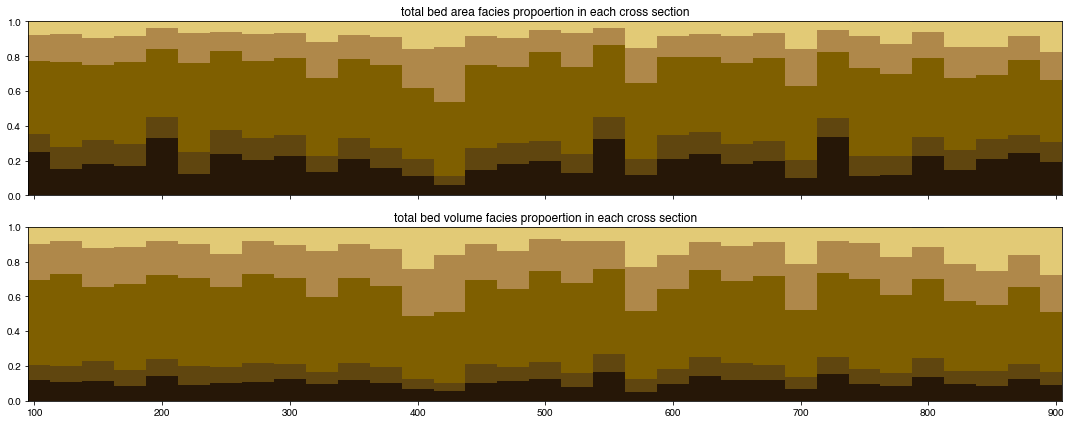

In [54]:
## Plot the total proportion of the section in each facies, time integrated
fig, ax = plt.subplots(2, figsize = (15, 6), tight_layout = True, sharex = True, sharey = True)
w = 25

int_area_bottoms = np.cumsum(total_area_prop, axis = 0)
int_vol_bottoms = np.cumsum(total_vol_prop, axis = 0)
ax[0].set_xlim(95, 905)
ax[0].set_ylim(0, 1)


ax[0].bar(sections, total_area_prop[0, :], w, color=clist[0])

for i in range(1, len(mmprange)-1):
    ax[0].bar(sections, total_area_prop[i, :], w, bottom = int_area_bottoms[i-1, :], color = clist[i])

ax[0].xaxis.set_minor_locator(MultipleLocator(100))
secstart = 100
secstop = 901
secspace = 25

ax[1].bar(sections, total_vol_prop[0, :], w, color=clist[0])

for i in range(1, len(mmprange)-1):
    ax[1].bar(sections, total_vol_prop[i, :], w, bottom = int_vol_bottoms[i-1, :], color = clist[i])

# for i in range(len(sections)):

ax[0].set_title('total bed area facies propoertion in each cross section')
ax[1].set_title('total bed volume facies propoertion in each cross section')

In [21]:
strat_perc_ub = np.sum(strat_percents[:2, :], axis = 0)
bed_perc_ub = np.sum(bed_percents[:2, :, -1], axis = 0)

Text(0.5, 0.98, 'Amount of the depositional bed volume in different facies')

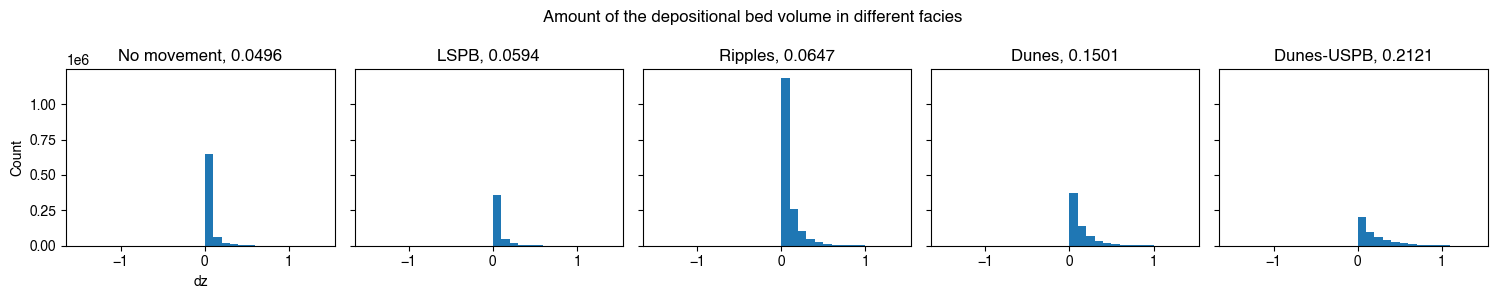

In [22]:
fig, ax = plt.subplots(1, 5, figsize = (15, 3), tight_layout = True, dpi = 100, sharex = True, sharey = True)

## plot histogram of bed thickness change for each timestep, sorted by facies--idk what the point of this was...
ax[0].hist(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0, mmp_to_faces[:, :, adjustment_time+1:]<0.01))].ravel(),bins = np.arange(-1.5, 1.5, 0.1));#, density = True);
ax[1].hist(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.01, mmp_to_faces[:, :, adjustment_time+1:]<0.025))].ravel(), bins = np.arange(-1.5, 1.5, 0.1));#, density = True);
ax[2].hist(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.025, mmp_to_faces[:, :, adjustment_time+1:]<0.17))].ravel(), bins = np.arange(-1.5, 1.5, 0.1));#, density = True);
ax[3].hist(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.17, mmp_to_faces[:, :, adjustment_time+1:]<0.35))].ravel(), bins = np.arange(-1.5, 1.5, 0.1));#, density = True);
ax[4].hist(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.35, mmp_to_faces[:, :, adjustment_time+1:]<1.5))].ravel(), bins = np.arange(-1.5, 1.5, 0.1));#, density = True);

ax[0].set_title(f'No movement, {np.round(np.nanmean(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0, mmp_to_faces[:, :, adjustment_time+1:]<0.01))]), 4)}')
ax[1].set_title(f'LSPB, {np.round(np.nanmean(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.01, mmp_to_faces[:, :, adjustment_time+1:]<0.017))]), 4)}')
ax[2].set_title(f'Ripples, {np.round(np.nanmean(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.017, mmp_to_faces[:, :, adjustment_time+1:]<0.025))]), 4)}')
ax[3].set_title(f'Dunes, {np.round(np.nanmean(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.25, mmp_to_faces[:, :, adjustment_time+1:]<0.35))]), 4)}')
ax[4].set_title(f'Dunes-USPB, {np.round(np.nanmean(dz_bed_facies[:, :, adjustment_time:][np.where(np.logical_and(mmp_to_faces[:, :, adjustment_time+1:]>=0.35, mmp_to_faces[:, :, adjustment_time+1:]<1.5))]), 4)}')

ax[0].set_xlabel('dz')
ax[0].set_ylabel('Count')

fig.suptitle('Amount of the depositional bed volume in different facies')

Text(0.5, 1.0, 'Area prop in complete strat section, per xs')

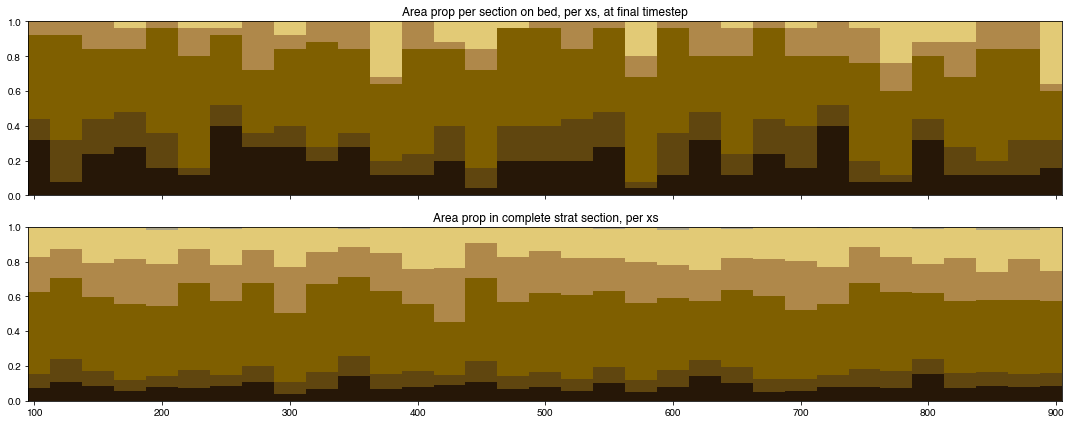

In [55]:
bedforms = ['no movement', 'lspb', 'ripples', 'dunes', 'dunes uspb', 'uspb']
fig, ax = plt.subplots(2, figsize = (15, 6), tight_layout = True, sharex = True, sharey = True)
w = 25
sec_t = -1 ## time you want to see the section abundances for, use -1 because the stratigraphy was only built for that, you cant use anything less than unless you rebuild strat at that time
bed_bottoms = np.cumsum(bed_percents[:, :, sec_t], axis = 0)
strat_bottoms = np.cumsum(strat_percents, axis = 0)
ax[0].set_xlim(95, 905)
ax[0].set_ylim(0, 1)
# for i in range (0, gridx, 10):
# for i in range(len(sections)):
ax[0].bar(sections, bed_percents[0, :, sec_t], w, color=clist[0])

for i in range(1, len(bedforms)):
    ax[0].bar(sections, bed_percents[i, :, sec_t], w, bottom = bed_bottoms[i-1, :], color = clist[i])
# for x in range (0, 1001, 10):
#     for i in range (1, len(xs_freq)):
        
# for x in range (len(sections)):
#     for i in range (1, len(bed_percents)):
#         #fac = plt.bar(x, xs_freq[i, x], w, bottom = np.sum(xs_freq[:i, x]), color = clist[i])
#         ax[0].bar(sections[x], bed_percents[i, x, -1], 10, bottom = np.sum(bed_percents[:i, x, -1]), color = clist[i-1])
# ax=plt.gca()
ax[0].xaxis.set_minor_locator(MultipleLocator(100))
# ax[0].axhline(0.15, c = 'r', ls = '--')
# ax[0].axhline(0.25, c = 'r', ls = '-')

secstart = 100
secstop = 901
secspace = 25

ax[1].bar(sections, strat_percents[0, :], w, color=clist[0])

for i in range(1, len(bedforms)):
    ax[1].bar(sections, strat_percents[i, :], w, bottom = strat_bottoms[i-1, :], color = clist[i])

# for i in range(len(sections)):
#     ax[1].bar(sections[i], strat_percents[0, i], 10, color=clist[0])

# for xpos in range(len(sections)):
#     for j in range (1, len(strat_freq)):
#         #fac = plt.bar(x, xs_freq[i, x], w, bottom = np.sum(xs_freq[:i, x]), color = clist[i])
#         ax[1].bar(sections[xpos], strat_percents[j, xpos], 10, bottom = np.sum(strat_percents[:j, xpos]), color = clist[j-1])
        
ax[1].xaxis.set_minor_locator(MultipleLocator(100))
# ax[1].axhline(0.15, c = 'r', ls = '--')
# ax[1].axhline(0.25, c = 'r', ls = '-')

ax[0].set_title('Area prop per section on bed, per xs, at final timestep')
ax[1].set_title('Area prop in complete strat section, per xs')

# ax[1].plot(sections, strat_perc_ub, 'r--', lw = 0, marker = '_')
# ax[0].plot(sections, bed_perc_ub, 'r--', lw = 0, marker = '_')
# # plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/skyscraper-facies.png', transparent = True)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/faciesskyscraper.png', transparent = True, dpi = 300)
# plt.savefig(f'{savefilesto}facies/facieshist{modelrun}.png', dpi = 300)

In [60]:
np.quantile(datamaster[:, 4, adjustment_time:], [.70, .9, .999])

array([1.27089083, 1.88449819, 4.26879837])

In [48]:
np.nanmean(delta_freq, axis = 1)

array([-50.07992633, -24.21568015,  -2.24310364,  36.10863229,
       123.44917306,          inf])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


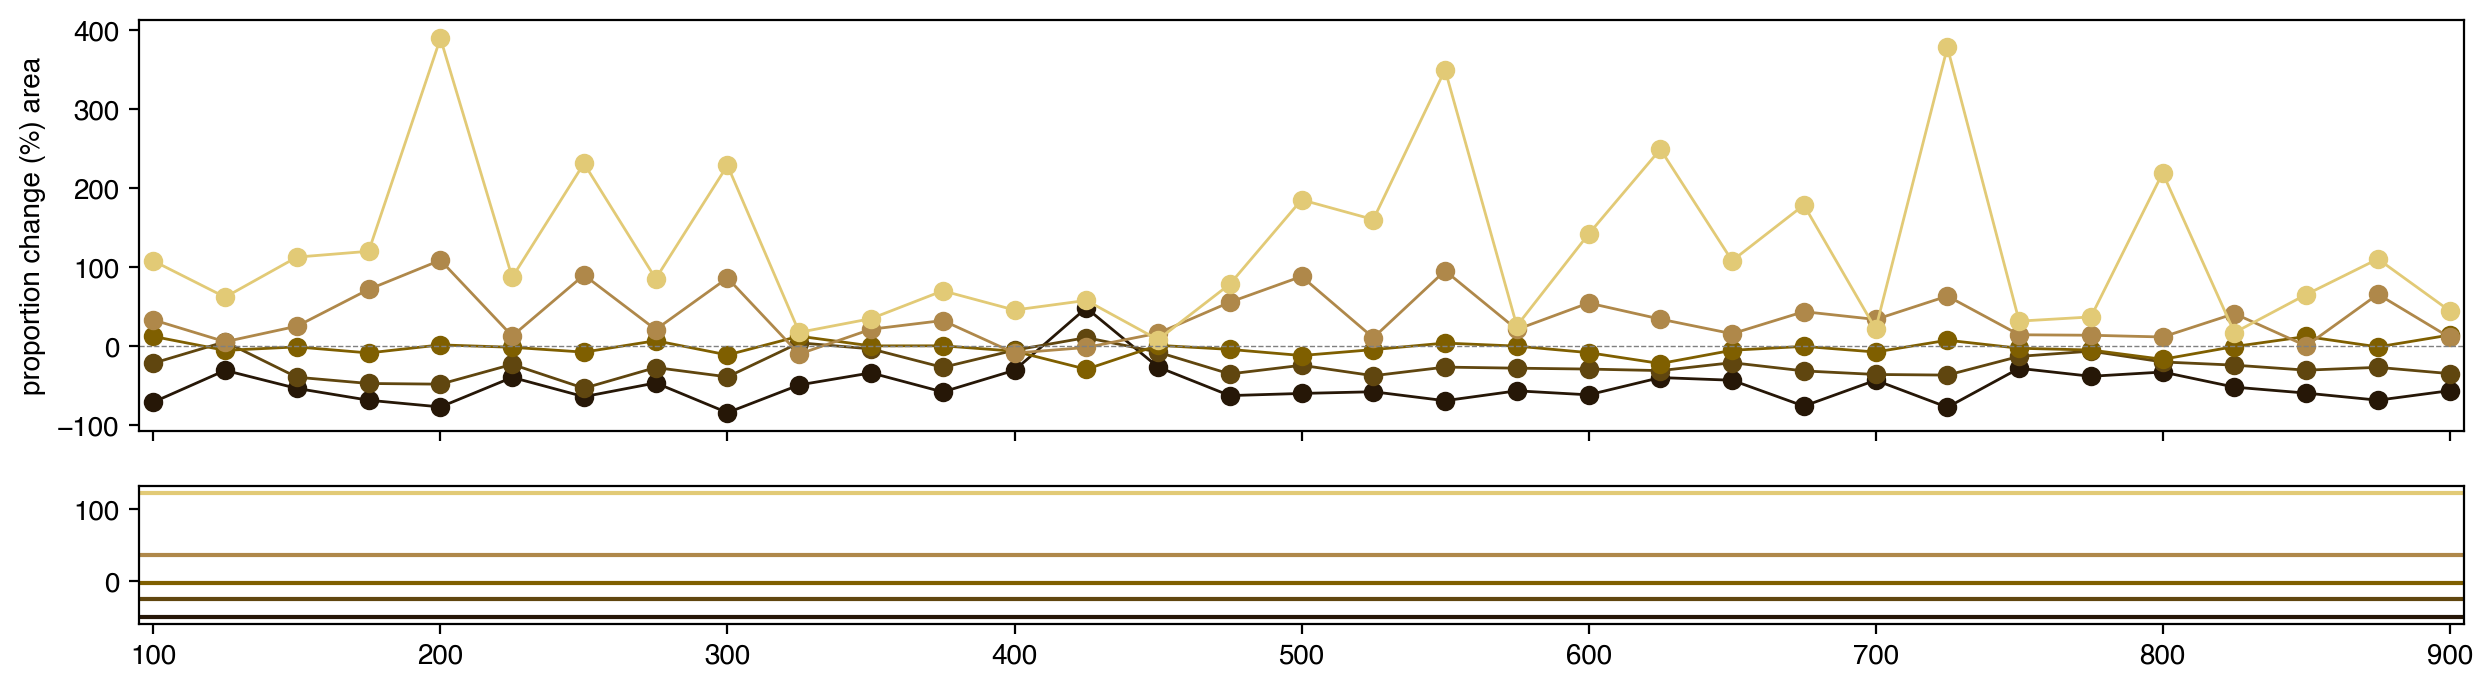

In [56]:
## calculate deltas between section volume and stratigraohic area.

delta_freq = ((strat_percents-total_area_prop)/total_area_prop)*100
fig, ax = plt.subplots(2, 1, figsize = (15, 4), dpi = 200, gridspec_kw={'height_ratios': [3, 1]}, sharex = True)

for fac in range(len(clist)-1):
    ax[0].plot(sections, delta_freq[fac, :], marker = 'o', lw = 1, c = clist[fac])
    ax[1].axhline(np.mean(delta_freq[fac, :]), c = clist[fac])
ax[1].set_xlim(95, 905)
ax[0].axhline(0, c = 'grey', lw = 0.5, ls = '--')
ax[0].set_ylabel('proportion change (%) area')
ax[0].set_facecolor('None')

#### Comparing bed conditions to averages from the stratgiraphy

#### Compare at the bar scale

In [29]:
## calculate the proportion in each bar
# bins are 0-0.025 LPB
#           0.025-0.17 RIP
#           0.17-0.35 DUN
#           0.35-1.5 DUN UP
#           1.5-10 UP
allbars = pd.DataFrame(columns = ['array name', 'iloc', 'PreservChar', 'no move', 'lspb', 'ripples', 'dunes', 'dunes uspb', 'uspb',
                                 'no move prop', 'lspb prop', 'ripples prop', 'dunes prop', 'dunes uspb prop', 'uspb prop'])

arrayfolder = 'agubh2_agu22-250m'
# init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/Summer-bpkg-redo/JULY142022'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{arrayfolder}'

for root, dirs, files in os.walk(init):
    for file in files:
        arr = np.load(os.path.join(root, file), allow_pickle = True)
        arrnm = file[:-4]
        iloc = file[:3]
        pres = file[4:6]
        mmp = arr[:, :, -1] ## the arrays already have the mmp values in them
        # mmpfreqs, edges = np.histogram(mmp.ravel(), bins = [0, 0.01, 0.025, 0.17, 0.35, 1.5, 10])
        
        # total = len(mmp.ravel())
        arr[:, :, 1][np.isnan(arr[:, :, -1])] = np.nan ## mask xy topo values?
        dz = arr[1:, :, 0]-arr[:-1, :, 0] ## 0 here is xy_topo
        
        dzm = np.ma.masked_where(np.isnan(arr[1:, :, -1]), dz)

        nomve = np.nansum(dzm[np.where(arr[1:, :, -1]<0.01)])

        lspb = np.nansum(dzm[np.where(np.logical_and(arr[1:, :, -1]>=0.01, arr[1:, :, -1]<0.025))])

        rip = np.nansum(dzm[np.where(np.logical_and(arr[1:, :, -1]>=0.025, arr[1:, :, -1]<0.17))])

        dun = np.nansum(dzm[np.where(np.logical_and(arr[1:, :, -1]>=0.17, arr[1:, :, -1]<0.35))])

        dunuspb = np.nansum(dzm[np.where(np.logical_and(arr[1:, :, -1]>=0.35, arr[1:, :, -1]<1.5))])

        uspb = np.nansum(dzm[np.where(arr[1:, :, -1]>=1.5)])

        if np.nansum(dz) == 0:
            print(file, np.nansum(dzm))
        else:
            props = [nomve, lspb, rip, dun, dunuspb, uspb]/(np.nansum(dzm))
#             print(np.nansum(props))
        
        areas = [nomve, lspb, rip, dun, dunuspb, uspb]

#         mmpprop = mmpfreqs/total
        
        test = pd.DataFrame([arrnm], columns = ['array name'])
        testil = pd.DataFrame([iloc], columns = ['iloc'])
        presgrade = pd.DataFrame([pres], columns = ['PreservChar'])
        
        
        dat = pd.DataFrame([areas], columns = ['no move', 'lspb', 'ripples', 'dunes', 'dunes uspb', 'uspb'])
        datprop = pd.DataFrame([props], columns = ['no move prop', 'lspb prop', 'ripples prop', 'dunes prop', 'dunes uspb prop', 'uspb prop'])
        
        # dat = pd.DataFrame(mmpfreqs.reshape(1, 6), columns = ['no move', 'lspb', 'ripples', 'dunes', 'dunes uspb', 'uspb'])
        # datprop = pd.DataFrame(mmpprop.reshape(1, 6), columns = ['no move prop', 'lspb prop', 'ripples prop', 'dunes prop', 'dunes uspb prop', 'uspb prop'])
        toadd = pd.concat((test, testil, presgrade, dat, datprop), axis = 1)
        
        allbars = pd.concat((allbars, toadd), axis = 0)
        
# allbars.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/concat-files/facies-props-agubh2-agu22-250m.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [30]:
allbars['ub prop'] = allbars['no move prop'] + allbars['lspb prop'] 
allbars['lb prop'] = allbars['dunes prop'] + allbars['dunes uspb prop'] + allbars['uspb prop']+ allbars['ripples prop']

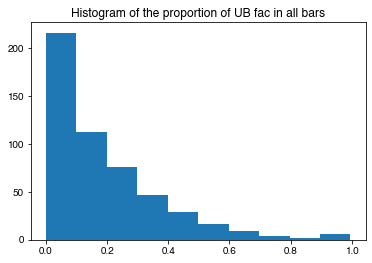

In [31]:
plt.hist(allbars['ub prop']);
plt.title('Histogram of the proportion of UB fac in all bars');

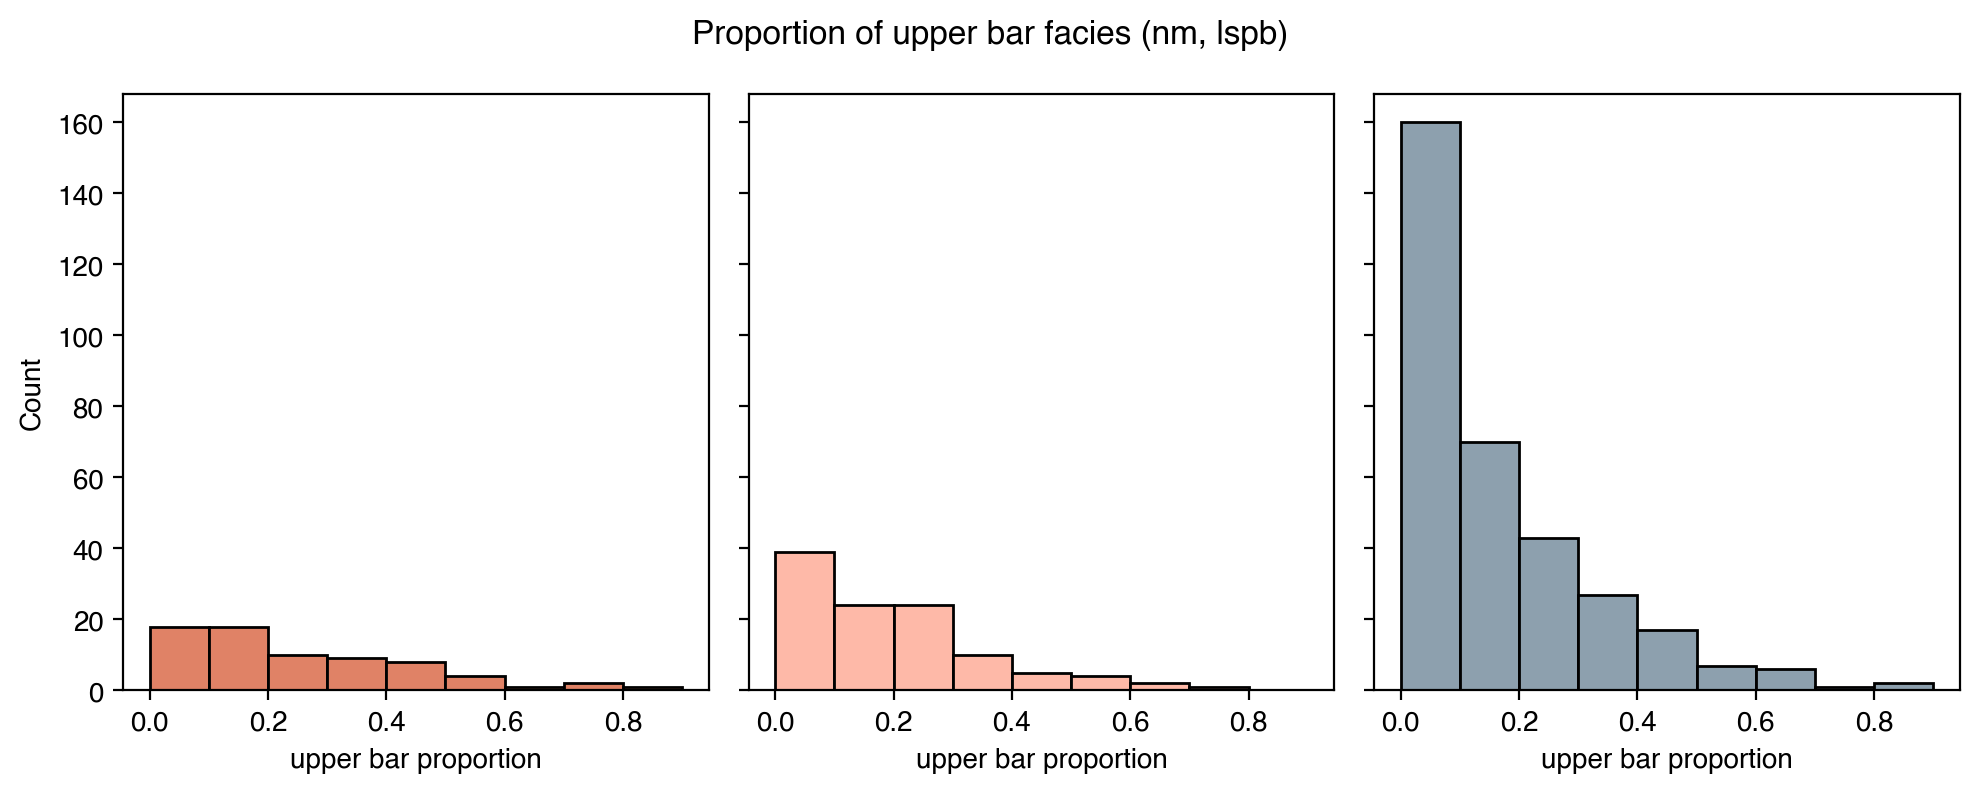

In [45]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, tight_layout = True, figsize = (10, 4), dpi = 200)

ax[0].hist(allbars['ub prop'][allbars['PreservChar']=='FP'], facecolor = pres_cols[0], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[1].hist(allbars['ub prop'][allbars['PreservChar']=='PP'], facecolor = pres_cols[1], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[2].hist(allbars['ub prop'][allbars['PreservChar']=='TR'], facecolor = pres_cols[2], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[0].set_ylabel('Count')
ax[0].set_xlabel('upper bar proportion')
ax[1].set_xlabel('upper bar proportion')
ax[2].set_xlabel('upper bar proportion')

fig.suptitle('Proportion of upper bar facies (nm, lspb)');

fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, tight_layout = True, figsize = (10, 4), dpi = 200)

ax[0].hist(allbars['lb prop'][allbars['PreservChar']=='FP'], facecolor = pres_cols[0], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[1].hist(allbars['lb prop'][allbars['PreservChar']=='PP'], facecolor = pres_cols[1], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[2].hist(allbars['lb prop'][allbars['PreservChar']=='TR'], facecolor = pres_cols[2], ec = 'k', bins = np.arange(0, 1, 0.1))
ax[0].set_ylabel('Count')
ax[0].set_xlabel('lower bar proportion')
ax[1].set_xlabel('lower bar proportion')
ax[2].set_xlabel('lower bar proportion')

fig.suptitle('Proportion of lower bar facies (rip, dunes, dunes-uspb, antidunes)');

In [48]:
allbars

,array name,iloc,PreservChar,no move,lspb,ripples,dunes,dunes uspb,uspb,no move prop,lspb prop,ripples prop,dunes prop,dunes uspb prop,uspb prop,ub prop,lb prop
0,100-FP-3-1,100,FP,9.613341,2.581337,11.357766,0.021342,0.0,--,0.407798,0.109500,0.481796,0.000905,0.000000,NaN,0.517298,NaN
0,100-FP-5-0,100,FP,1.085288,2.179373,17.36927,8.819991,15.466305,--,0.024160,0.048517,0.386669,0.196348,0.344306,NaN,0.072677,NaN
0,100-FP-5-22,100,FP,0.0,0.0,2.276564,6.272429,0.324285,--,0.000000,0.000000,0.256564,0.706890,0.036546,NaN,0.000000,NaN
0,100-FP-5-9,100,FP,1.018038,1.437072,15.08775,3.292737,10.265116,--,0.032734,0.046207,0.485126,0.105873,0.330060,NaN,0.078941,NaN
0,100-PP-4-10,100,PP,3.753532,8.554571,27.624803,1.051774,--,--,0.091584,0.208726,0.674028,0.025663,NaN,NaN,0.300310,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,900-TR-3-8,900,TR,0.369621,0.467226,15.356188,8.07138,11.505992,--,0.010333,0.013062,0.429299,0.225644,0.321662,NaN,0.023395,NaN
0,900-TR-4-1,900,TR,1.785976,0.150344,1.460494,2.15639,2.946451,--,0.210123,0.017688,0.171830,0.253703,0.346655,NaN,0.227812,NaN
0,900-TR-4-10,900,TR,0.043892,0.485746,1.497105,2.783629,0.019314,--,0.009088,0.100575,0.309980,0.576358,0.003999,NaN,0.109663,NaN
0,900-TR-4-14,900,TR,0.523273,0.893497,1.036702,1.112405,0.0,--,0.146745,0.250569,0.290728,0.311958,0.000000,NaN,0.397313,NaN


AttributeError: module 'seaborn' has no attribute 'histplot'

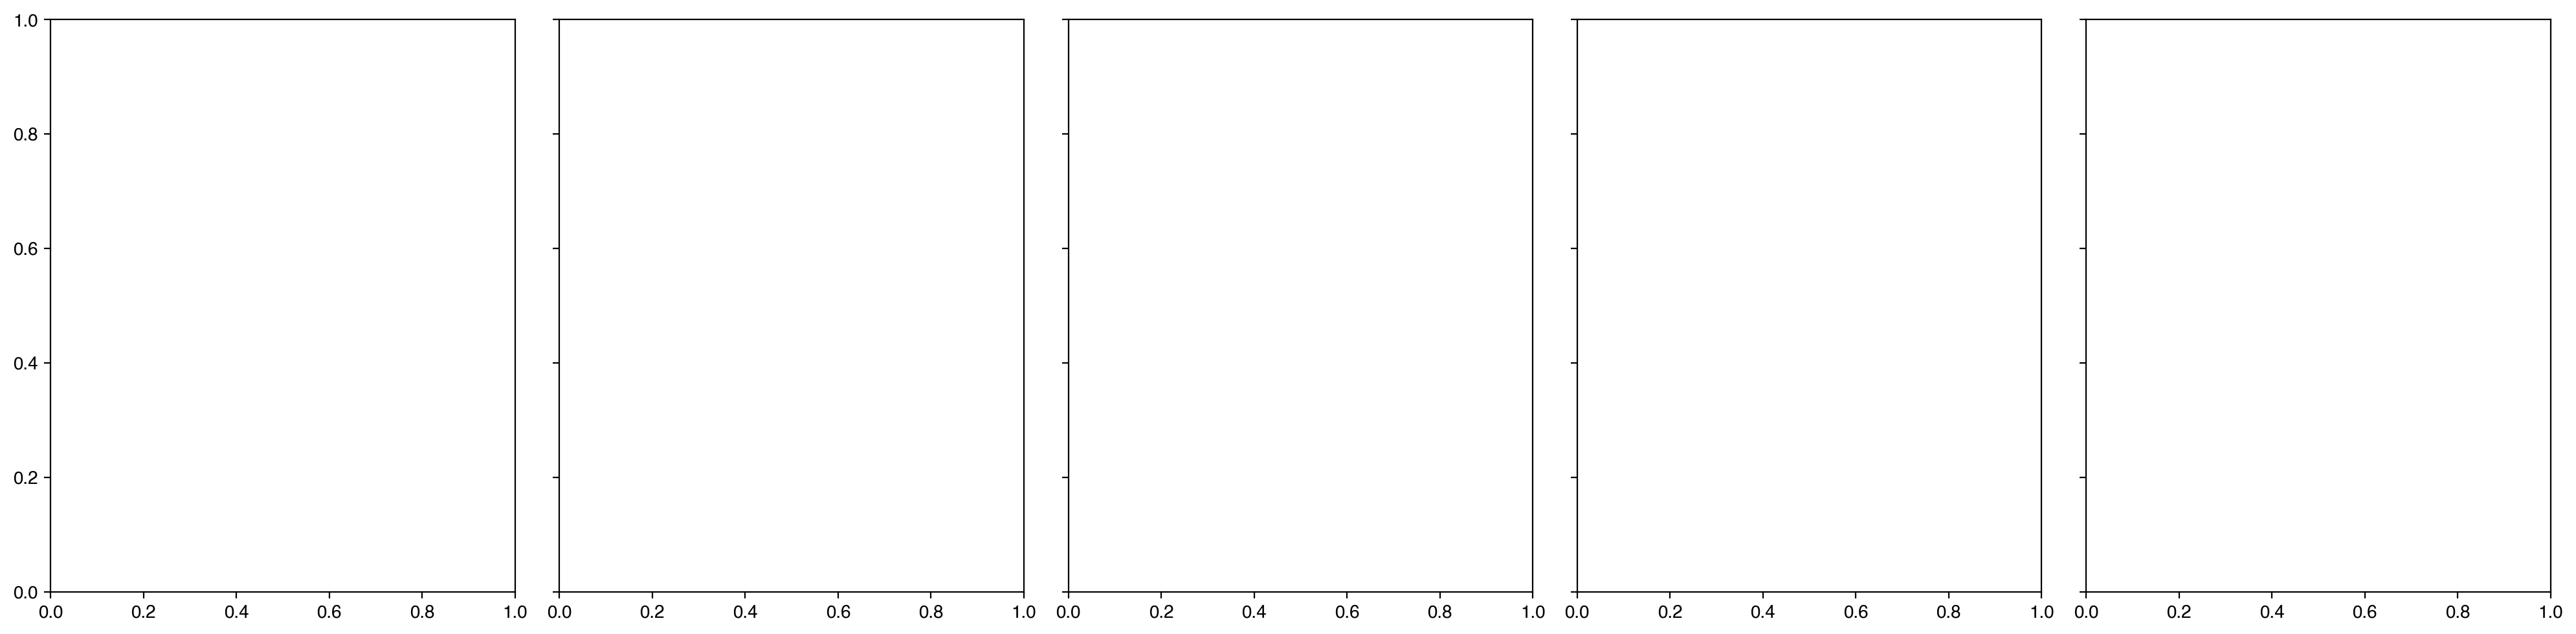

In [47]:
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, tight_layout = True, figsize = (20, 5), dpi  =200)
             
sns.histplot(data = allbars, x = 'no move prop', ax = ax[0], hue = 'PreservChar', stat = 'percent', palette = pres_palette, binwidth = .05, multiple = 'dodge')
sns.histplot(data = allbars, x = 'lspb prop', ax = ax[1], hue = 'PreservChar', stat = 'percent', palette = pres_palette, binwidth = .05, multiple = 'dodge')
sns.histplot(data = allbars, x = 'dunes prop', ax = ax[2], hue = 'PreservChar', stat = 'percent', palette = pres_palette, binwidth = .05, multiple = 'dodge')
sns.histplot(data = allbars, x = 'dunes uspb prop', ax = ax[3], hue = 'PreservChar', stat = 'percent', palette = pres_palette, binwidth = .05, multiple = 'dodge')
sns.histplot(data = allbars, x = 'uspb prop', ax = ax[4], hue = 'PreservChar', stat = 'percent', palette = pres_palette, binwidth = .05, multiple = 'dodge')

allbars.to_csv()

0 = i, 1 = j, 2 = x, 3 = y, 4 = depth, 5 = elevation, 6 = shear stress, 7 = elevation change, 8 = Froude, 9 = shields, 10 = velocity, 11=bedload flux

___
# Summary Statistics?

In [17]:
## how much of the bed above critical shear at any time?
above_crit = np.array([])
above_mean = np.array([])
above_median = np.array([])
above_p75 = np.array([])
above_p90 = np.array([])
bedcells = datamaster.shape[0]

#lamb_critshear = crit_shields*(rhos-rhow)*g*d50 ## using lamb eqn to find crit shields and redimensionalise it
##using shields number
smean = np.mean(datamaster[:, 9, :])
smedian =np.median(datamaster[:, 9, :])
sp75 = np.quantile(datamaster[:, 9, :], 0.75)
sp90 = np.quantile(datamaster[:, 9, :], 0.9)
for t in range (end_t):
    abcrit = len(np.where(datamaster[:, 9, t]>=crit_shields)[0])/bedcells
    abmean = len(np.where(datamaster[:, 9, t]>=smean)[0])/bedcells
    abmed = len(np.where(datamaster[:, 9, t]>=smedian)[0])/bedcells
    abp75 = len(np.where(datamaster[:, 9, t]>=sp75)[0])/bedcells
    abp90 = len(np.where(datamaster[:, 9, t]>=sp90)[0])/bedcells
    
    above_crit = np.append(above_crit, abcrit)
    above_mean = np.append(above_mean, abmean)
    above_median = np.append(above_median, abmed)
    above_p75 = np.append(above_p75, abp75)
    above_p90 = np.append(above_p90, abp90)

In [18]:
avg_depth = np.average(datamaster[:, 4, :], axis = 0)
med_depth = np.median(datamaster[:, 4, :], axis = 0)

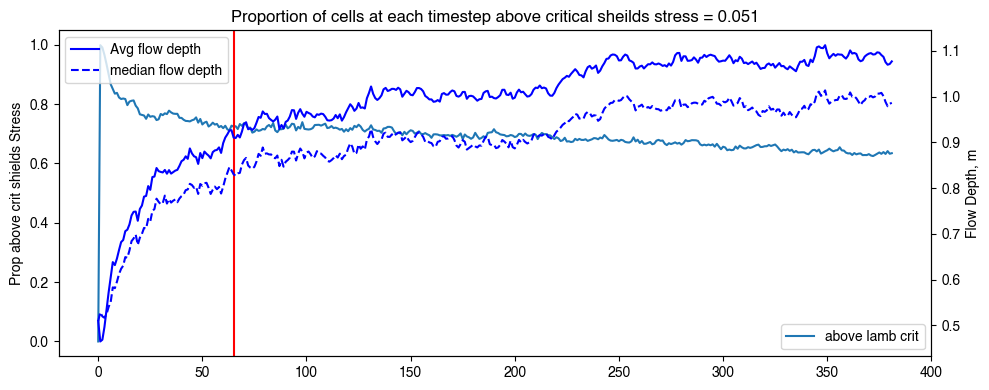

In [24]:
adjustment_time = 65
plt.figure(figsize = (10, 4), tight_layout = True, dpi = 100)
plt.plot(above_crit, label = 'above lamb crit')
plt.axvline(65, c = 'r')
plt.legend(loc = 'lower right')
plt.ylabel('Prop above crit shields Stress')
plt.title(f'Proportion of cells at each timestep above critical sheilds stress = {np.round(crit_shields, 3)}')

ax = plt.gca()
ax1 = ax.twinx()
ax1.plot(avg_depth, 'b', label = 'Avg flow depth')
ax1.plot(med_depth, 'b--', label = 'median flow depth')

ax1.set_ylabel('Flow Depth, m')
ax1.legend()

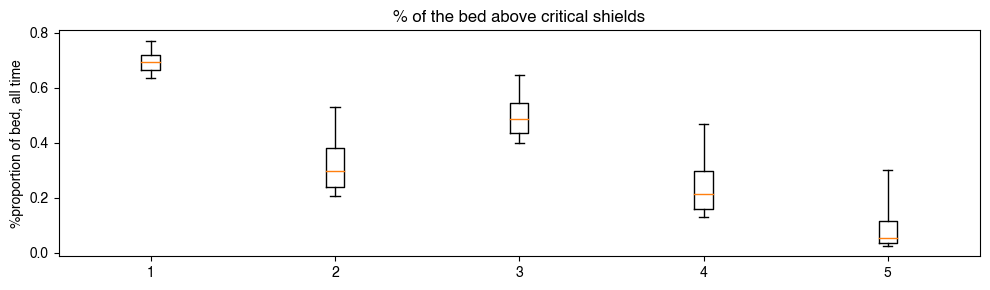

In [25]:
plt.figure(figsize = (10, 3), dpi = 100, tight_layout = True)
plt.title('% of the bed above critical shields')
plt.ylabel('%proportion of bed, all time')
plt.boxplot([above_crit, above_mean, above_median, above_p75, above_p90], whis=(5, 95), showfliers = False, widths = 0.1);

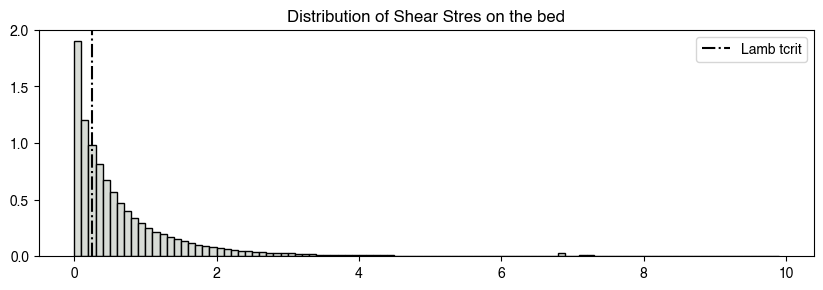

In [26]:
plt.figure(figsize = (10, 3), dpi = 100)
plt.hist(datamaster[:, 6, :].ravel(), bins = np.arange(0, 10, 0.1), density = True, ec = 'k', fc = 'xkcd:light grey');
plt.title('Distribution of Shear Stres on the bed')

plt.axvline(lamb_critshear, c = 'k', ls = '-.', label = 'Lamb tcrit')
plt.legend()

In [ ]:
n = 0.012 ##mannings
rhow = 1000
rhos = 2650 ##kgm3
sg = (rhos-rhow)/rhow
S = 0.013
g = 9.81
d50 = 0.31e-3 ##d50 in m
crit_shields = 0.15*S**0.25
print('Critical shield stress', crit_shields)

## Set up the meshgrid to plot the surface

## Calculate sediment flux across the channel 
(bedload flux using MPM and tcrit parameterisation from Lamb et al., 2008)

Just a check to set the colorbar 

func = interpolate.interp2d(xdomain, ydomain, elev, kind = 'cubic')
newelev = 

### Plot the channel full domain. You can prob just keep closed

Time series snapshot of the channel, also kinda useless, maybe useful with facies?

____
# Look at widening trends across the domain

## Mapping reworking

## Code block to run reach scale time series evol of the bed

#%matplotlib notebook
## create a series of snapshots of the channel reach 
adjtime = int(input('Enter adjustment timestep: ')) #time taken for the reworking curve to flatten out
#numtimes = int(end_t//adjtime)
numtimes = len(np.arange(10, end_t-1, adjtime))
print(numtimes)
numplots = 10 #we want 5 sublots of the reach
fig, ax = plt.subplots(numtimes, numplots, figsize = (25, 15), sharex=False, sharey=True, tight_layout=True, squeeze=True)
fig.subplots_adjust(hspace=.05, wspace = .1)

ax[0, 0].set_ylim(ydomain.min(), ydomain.max())

ts = np.arange(10, end_t-1, adjtime).astype(int)
for t, ts in zip(np.arange(0, numtimes), ts): 
    start = 0
    stop = 1000
    for p, r in zip(range(0, numplots), np.arange(0, 10000, 1000)):
        ax[t, p].pcolormesh(np.reshape(datamaster[:, 2, ts], (gridy, gridx)), 
                            np.reshape(datamaster[:, 3, ts], (gridy, gridx)),
                            np.reshape(datamaster[:, char, ts], (gridy, gridx)),
                            cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
        ax[t, p].set_aspect('equal')
        ax[t, p].set_title(f'T = {ts*interval_to_plot} hrs')
        ax[t, p].xaxis.set_minor_locator(MultipleLocator(100))
        ax[t, p].set_xlim(start+r, stop+r)
plt.savefig(f'{savefilesto}timeseries/multi-{modelrun}.png', dpi = 500)

In [ ]:
strat_percents.shape

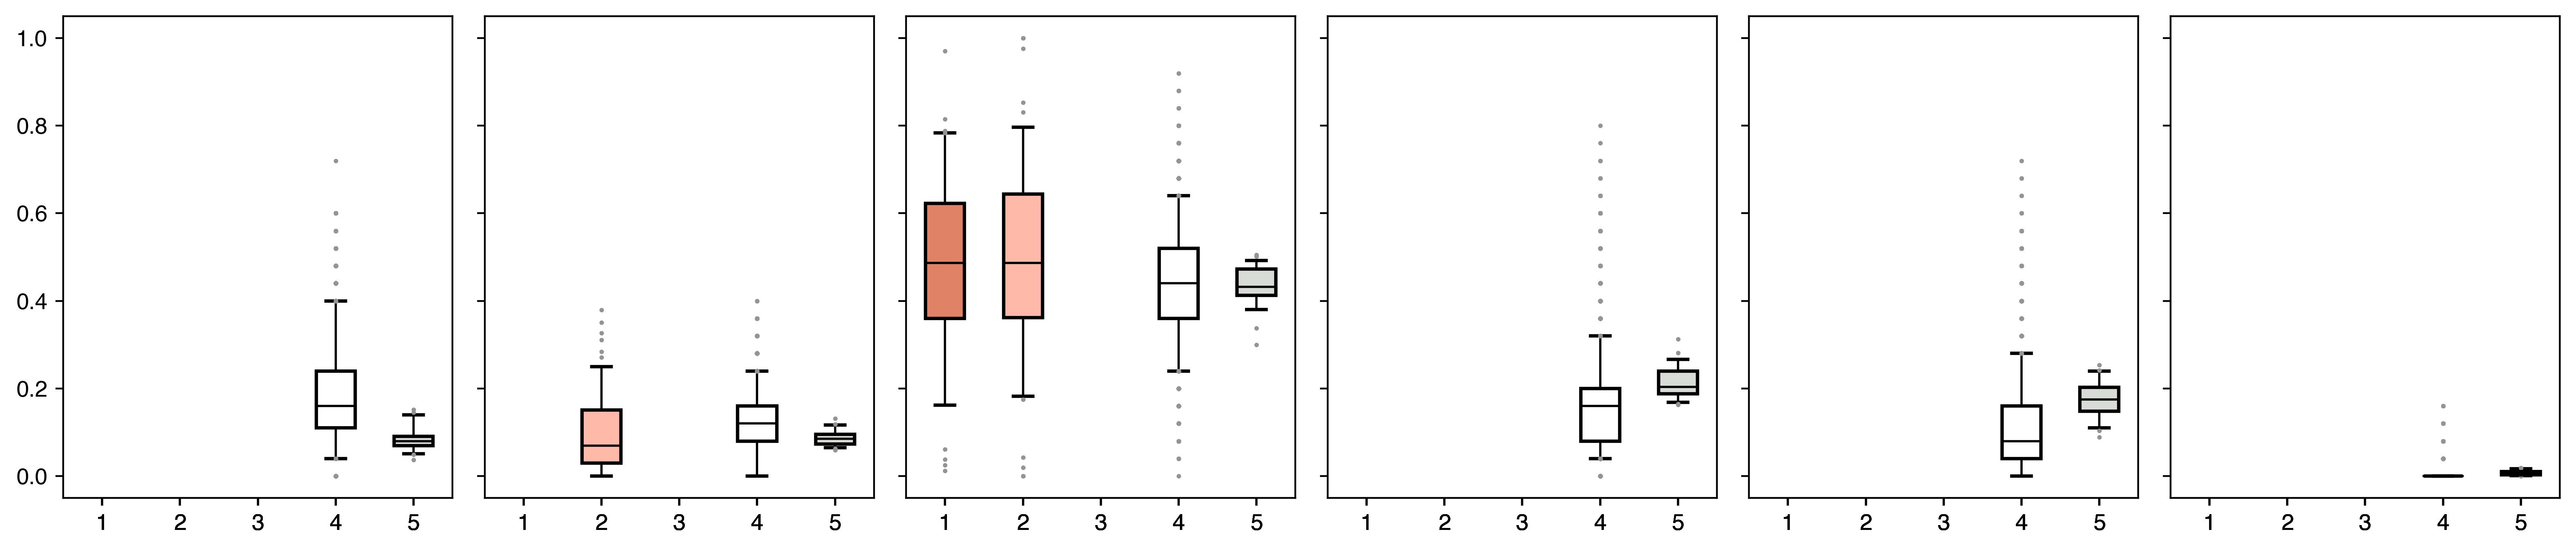

In [71]:
fig, ax = plt.subplots(1, 6, sharex = True, sharey = True, tight_layout = True, figsize = (16, 3.5), dpi = 400, squeeze = True)

flierprops = dict(marker='.', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
boxprops = dict(color = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = .5
medianprops = dict(color = 'k')
linewidth = 1.5


bplot1 = ax[0].boxplot([
    allbars['no move prop'][allbars['PreservChar']=='FP'], 
    allbars['no move prop'][allbars['PreservChar']=='PP'], 
    allbars['no move prop'][allbars['PreservChar']=='TR'], 
    bed_percents[0, :, :].ravel(), 
    strat_percents[0, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

bplot2 = ax[1].boxplot([
    allbars['lspb prop'][allbars['PreservChar']=='FP'], 
    allbars['lspb prop'][allbars['PreservChar']=='PP'], 
    allbars['lspb prop'][allbars['PreservChar']=='TR'], 
    bed_percents[1, :, :].ravel(), 
    strat_percents[1, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

bplot3 = ax[2].boxplot([
    allbars['ripples prop'][allbars['PreservChar']=='FP'], 
    allbars['ripples prop'][allbars['PreservChar']=='PP'], 
    allbars['ripples prop'][allbars['PreservChar']=='TR'], 
    bed_percents[2, :, :].ravel(), 
    strat_percents[2, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

bplot4 = ax[3].boxplot([
    allbars['dunes prop'][allbars['PreservChar']=='FP'], 
    allbars['dunes prop'][allbars['PreservChar']=='PP'], 
    allbars['dunes prop'][allbars['PreservChar']=='TR'], 
    bed_percents[3, :, :].ravel(), 
    strat_percents[3, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

bplot5 = ax[4].boxplot([
    allbars['dunes uspb prop'][allbars['PreservChar']=='FP'], 
    allbars['dunes uspb prop'][allbars['PreservChar']=='PP'], 
    allbars['dunes uspb prop'][allbars['PreservChar']=='TR'], 
    bed_percents[4, :, :].ravel(), 
    strat_percents[4, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

bplot6 = ax[5].boxplot([
    allbars['uspb prop'][allbars['PreservChar']=='FP'], 
    allbars['uspb prop'][allbars['PreservChar']=='PP'], 
    allbars['uspb prop'][allbars['PreservChar']=='TR'], 
    bed_percents[5, :, :].ravel(), 
    strat_percents[5, :].ravel()], 
    widths = boxwidth, notch = False, showfliers = True, 
    boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, patch_artist = True, medianprops = medianprops)

colors = ['#e08266', '#feb9a8', '#8da0ae', 'w', 'xkcd:light gray']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5, bplot6):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
    # for mean in 
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/barandbed_box.png', dpi = 300, transparent = True)

In [ ]:
bplot1

In [ ]:
ublb_bins = [0, 0.2, 10]
xs_freq_ublb = np.empty([len(mmprange)-1, mmp_reshape.shape[1]]) 
xs_freq_ublb_edges = np.empty([len(mmprange), mmp_reshape.shape[1]])
xs_percents_ublb = np.empty_like(xs_freq_ublb)
print(xs_freq_ublb.shape, xs_freq_ublb_edges.shape)
for x in range (0, mmp_reshape.shape[1]):
    xs_freq_ublb[:, x], xs_freq_ublb_edges[:, x] = np.histogram(mmp_reshape[:, x, :].ravel(), bins = ublb_bins) 
    xs_percents_ublb[:, x] = xs_freq_ublb[:, x]/(gridy*mmp_reshape.shape[2])
    
fig = plt.figure(figsize = (15, 3), tight_layout = True)
w = 1
plt.xlim(0, gridx)
plt.ylim(0, 1)
for i in range (0, gridx):
    plt.bar(i, xs_percents[0, i], w, color=clist[0])
for x in range (0, 1001):
    for i in range (1, len(xs_freq)):
        #fac = plt.bar(x, xs_freq[i, x], w, bottom = np.sum(xs_freq[:i, x]), color = clist[i])
        plt.bar(x, xs_percents[i, x], w, bottom = np.sum(xs_percents[:i, x]), color = clist[i-1])
ax=plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.axhline(0.15, c = 'r', ls = '--')
ax.axhline(0.25, c = 'r', ls = '-')

In [ ]:
reach_raw = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/chan-widths/CW-{datnam}')
reach_raw = reach_raw[:, :, :num_timesteps]
## create array to store the statiistics on the channel width for the full reach 
## This is a end_t x 3 array with min, max and mean reach width
max_chw = reach_raw[:, 2].max(axis=0)
min_chw = reach_raw[:, 2].min(axis=0)
reach_raw = np.concatenate((reach_raw, np.empty([len(reach_raw), 1, end_t])), axis = 1)
print(reach_raw.shape)
for i in range (0, end_t-1):
    reach_raw[:, 3, i] = (reach_raw[:, 2, i+1]-reach_raw[:, 2, i])/interval_to_plot #find and append reach data with widening rate, PER HOUR
    

In [ ]:
np.reshape(datamaster[ :, 3, 64] , (gridy, gridx)).shape


In [ ]:
## plot facies on the bed at different timesteps

warnings.filterwarnings("ignore")

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev_final = np.reshape(mmp_reshape[:, :, -1], (gridy, gridx)) ##using flow depth to plot

fig, ax = plt.subplots(5, figsize = (13, 7), tight_layout = True, dpi = 200, sharey = True)
fig.subplots_adjust(hspace=.1)

times_dem = [63, 129, 184, 249, 309]

for a, t in enumerate(times_dem):
    ax[a].pcolormesh(np.reshape(datamaster[:, 2, t], (gridy, gridx)), 
                            np.reshape(datamaster[ :, 3, t] , (gridy, gridx)), 
                            np.reshape(mmp_reshape[:, :, t].T, (gridy, gridx)),
                            cmap = cmap_vvfac, norm = norm_vvfac, alpha = 1)
    ax[a].xaxis.set_minor_locator(MultipleLocator(100))
    ax[a].set_aspect('equal')
    ax[a].set_xlim(500, 9990)
    ax[a].set_ylabel(t)
# #plt.savefig(f'{savefilesto}planformchange/PF{modelrun}.png', dpi=100)

# #plt.close(fig)

In [ ]:
sandiest_section = int(input('Enter sandiest area, div by 10: '))
muddiest_section = int(input('Enter muddiest area, div by 10: '))
early_time = int(input('Enter early time check: '))
late_time = int(input('Enter late time check: '))

In [ ]:
labels = ['No Movement', 'LSPB', 'Ripples', 'Dunes', 'USPB-Dunes', 'USPB']
sand_sizes = xs_percents[:, sandiest_section]*100
mud_sizes = xs_percents[:, muddiest_section]*100
e_time = ts_percents[:, early_time]*100
l_time = ts_percents[:, late_time]*100

    
fig, ax = plt.subplots(1,4, figsize = (12, 6), tight_layout = True)
sandiestpie = ax[0].pie(sand_sizes, labels = labels, colors = clist);
muddiestpie = ax[1].pie(mud_sizes, labels = labels, colors = clist)
earliestpie = ax[2].pie(e_time, labels = labels, colors = clist)
latestpie = ax[3].pie(l_time, labels = labels, colors = clist)

plt.savefig(f'{savefilesto}pies.png', dpi = 200)

In [ ]:
#times = [65, 95, 130, 160, 195, 230, 260, 290, 325, 350, 380]
times = np.arange(65, end_t, 7)
t = (len(times))
fig, ax = plt.subplots(t, 1, figsize =(15, t+4), dpi = 300, sharex = True, sharey = True, tight_layout = True)

ax = ax.ravel()
for idx, t in enumerate(times):
    ax[idx].pcolormesh(np.reshape(datamaster[:, 2, t], (gridy, gridx)), 
                     np.reshape(datamaster[:, 3, t], (gridy, gridx)),
                     np.reshape(datamaster[:, char, t], (gridy, gridx)),
                     cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
    ax[idx].set_aspect('equal')
    #ax[a].set_title(f'Timestep: {int(ts*interval_to_plot)}')
    #ax[a].axvline(xsloc, c='r',ls = '--')
    ax[idx].xaxis.set_minor_locator(MultipleLocator(100))
    
    ax[idx].xaxis.set_major_locator(MultipleLocator(1000))

    ax[idx].grid(axis = 'x', which = 'both', alpha = 0.3)
    ax[idx].set_ylabel(t)
    
# plt.savefig(f'{savefilesto}timeseries/full-{modelrun}.png', dpi=300)
